In [4]:
import torch
import os
import torch.nn as nn
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.transforms import ToTensor, Resize, Compose
import os, argparse, time, subprocess, io, shlex, pickle, pprint
import pandas as pd
import numpy as np
import tqdm


In [12]:
torch.cuda.is_available()

True

In [13]:
torch.cuda.device_count()

1

In [15]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Dataset

loading annotations into memory...
Done (t=31.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
torch.Size([32, 3, 500, 333]) [tensor([[3.5486e+02, 2.2080e+01, 1.4514e+02, 1.7820e+02, 7.2000e+01, 3.0304e+05,
         3.5639e+04],
        [9.1850e+01, 8.8480e+01, 2.2416e+02, 1.3652e+02, 7.3000e+01, 3.0304e+05,
         1.0990e+06],
        [5.1540e+01, 2.7314e+02, 3.9646e+02, 5.4730e+01, 7.6000e+01, 3.0304e+05,
         1.1148e+06],
        [3.4761e+02, 2.0730e+02, 6.8970e+01, 6.2590e+01, 4.7000e+01, 3.0304e+05,
         1.5047e+06],
        [4.6079e+02, 2.6646e+02, 3.9210e+01, 4.6870e+01, 7.7000e+01, 3.0304e+05,
         1.9759e+06],
        [1.2524e+02, 2.2311e+02, 1.6262e+02, 3.6130e+01, 8.4000e+01, 3.0304e+05,
         1.9846e+06],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,


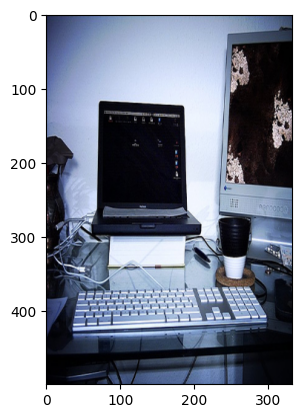

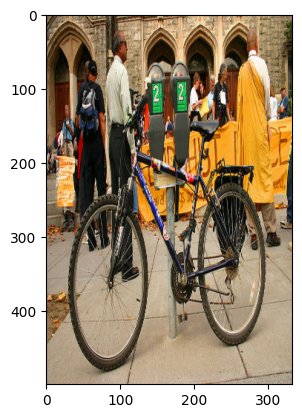

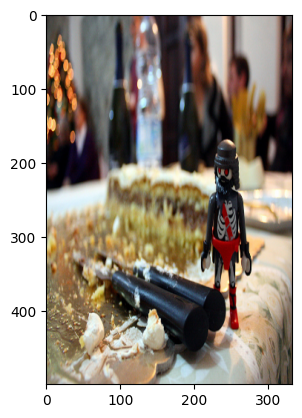

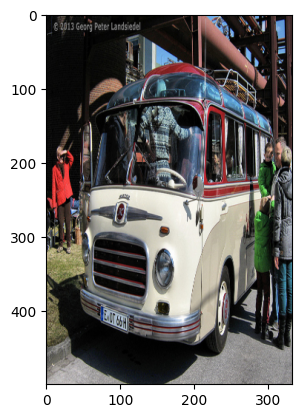

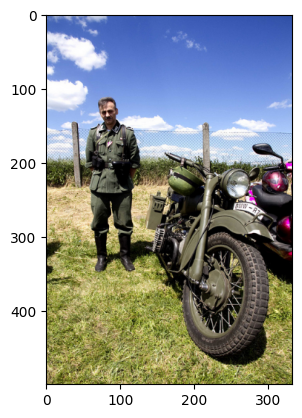

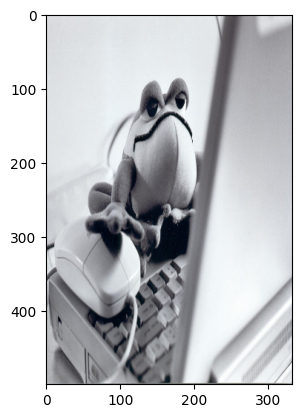

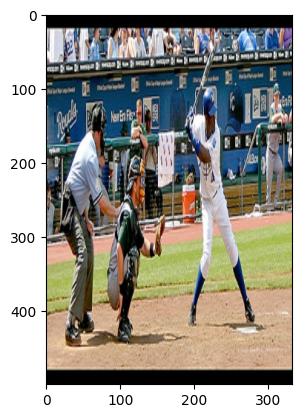

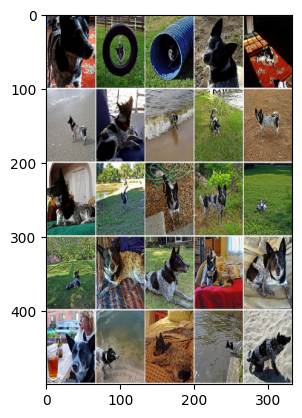

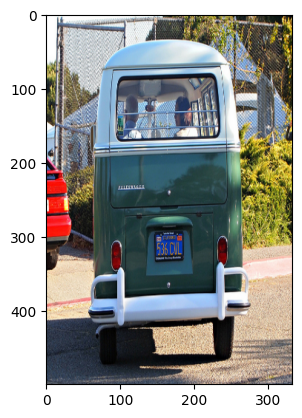

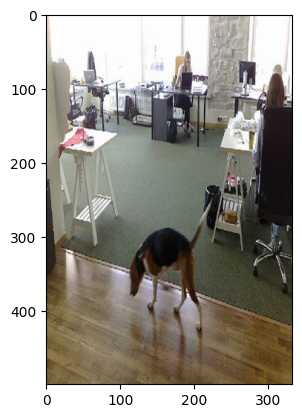

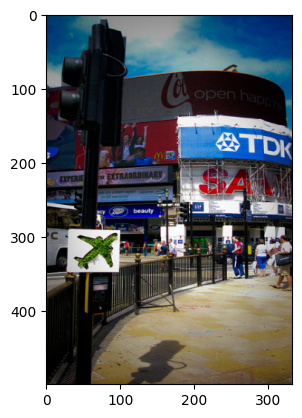

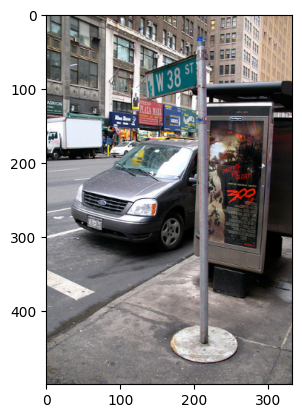

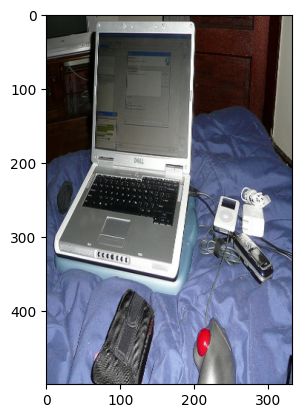

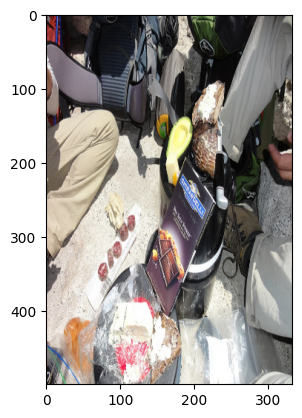

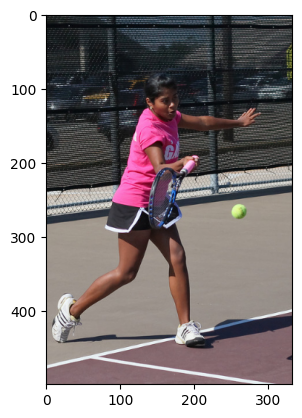

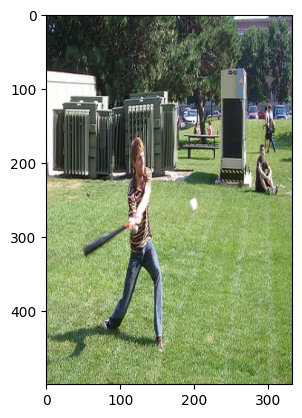

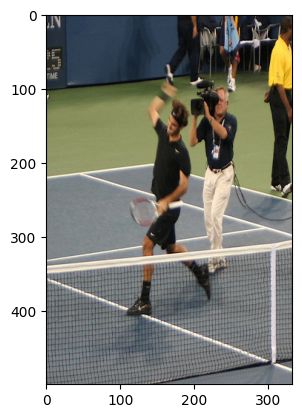

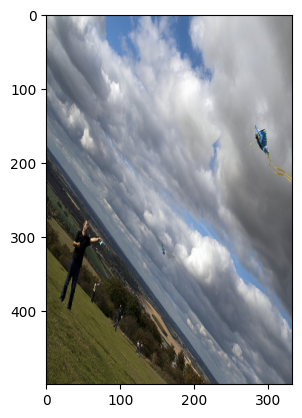

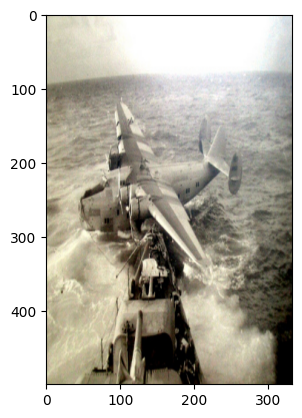

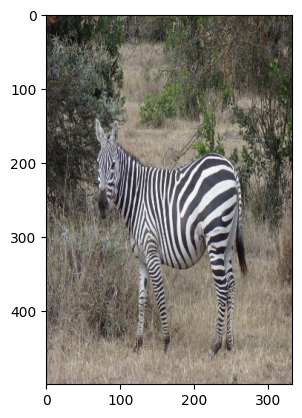

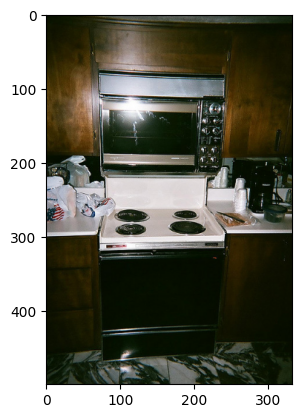

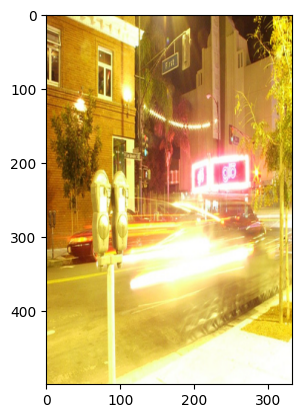

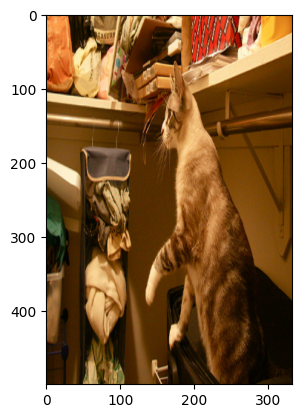

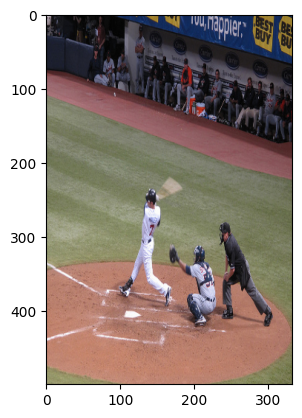

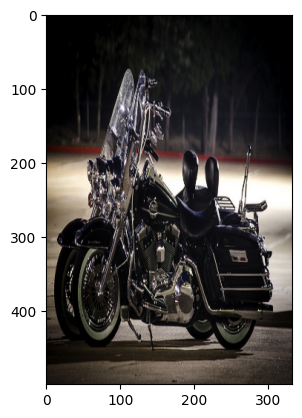

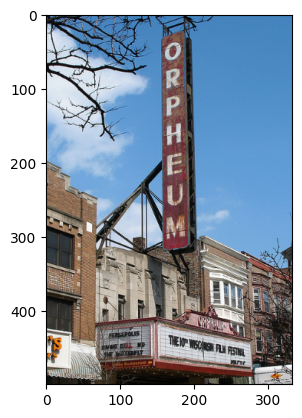

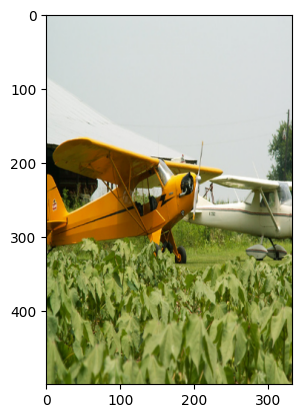

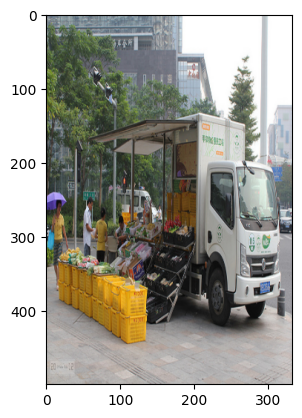

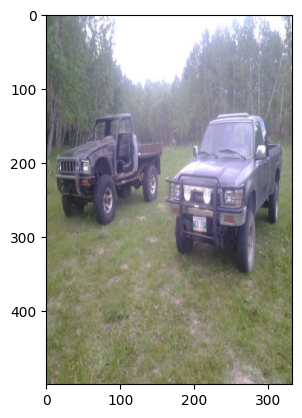

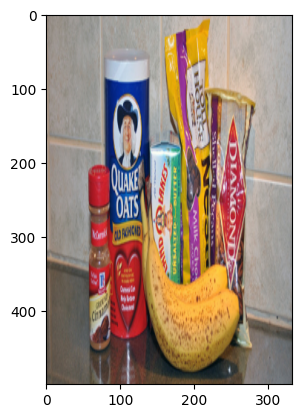

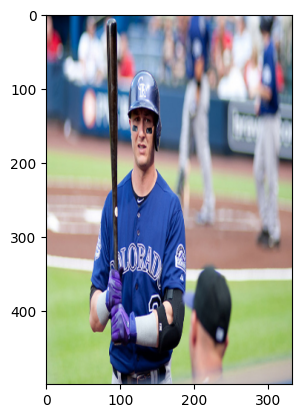

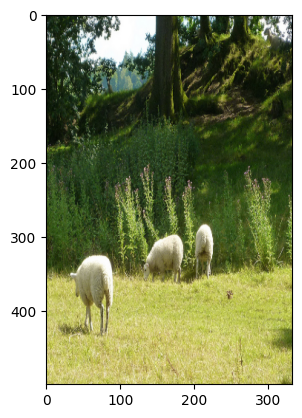

tensor([[354.8600,  22.0800, 145.1400, 178.2000],
        [ 91.8500,  88.4800, 224.1600, 136.5200],
        [ 51.5400, 273.1400, 396.4600,  54.7300],
        [347.6100, 207.3000,  68.9700,  62.5900],
        [460.7900, 266.4600,  39.2100,  46.8700],
        [125.2400, 223.1100, 162.6200,  36.1300],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CocoDatasetLoader:
    def __init__(self, coco_root_train, coco_root_val, transform=None, batch_size=32, num_workers=0):
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.coco_root_train = os.path.join(coco_root_train)
        self.coco_root_val = os.path.join(coco_root_val)

    def create_coco_dataset(self, root, ann_file):
        return CocoDetection(root=root, annFile=ann_file, transform=self.transform)\
     
    def target_to_tensor(self, target):
        # Extract bounding boxes and labels
        boxes = [obj['bbox'] for obj in target]
        labels = [obj['category_id'] for obj in target]
        image_ids = [obj['image_id'] for obj in target]
        ids = [obj['id'] for obj in target]

        # Pad boxes and labels to a fixed length
        max_len = 5  # Replace with your actual maximum length
        while len(boxes) < max_len:
            boxes.append([0, 0, 0, 0])
            labels.append(0)
            image_ids.append(0)
            ids.append(0)

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float64)
        labels = torch.tensor(labels, dtype=torch.int64)
        image_ids = torch.tensor(image_ids, dtype=torch.int64)
        ids = torch.tensor(ids, dtype=torch.int64)

        # Concatenate boxes and labels
        data = torch.cat((boxes, labels.unsqueeze(1), image_ids.unsqueeze(1), ids.unsqueeze(1)), dim=-1)

        return data
                
    # Function to pad targets to the same size
    def pad_targets(self,batch):
        images, targets = zip(*batch)
        targets = [self.target_to_tensor(t) for t in targets]
        targets = pad_sequence(targets, batch_first=True, padding_value=0)
        return torch.stack(images), targets

    def get_data_loaders(self):
        coco_dataset_train = self.create_coco_dataset(root=self.coco_root_train, ann_file="./annotations/instances_train2017.json")
        coco_dataset_val = self.create_coco_dataset(root=self.coco_root_val, ann_file="./annotations/instances_val2017.json")

        dataloader_train = DataLoader(coco_dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=self.pad_targets)
        dataloader_val = DataLoader(coco_dataset_val, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=self.pad_targets)

        return dataloader_train, dataloader_val

# Usage
coco_loader = CocoDatasetLoader(coco_root_train="./coco_dataset_test/train2017",
                                coco_root_val="./coco_dataset_test/val2017",
                                transform=transforms.Compose([ToTensor(), Resize((500, 333))
                                                              ]))

dataloader_train, dataloader_val = coco_loader.get_data_loaders()

for batch in dataloader_train:
    images, targets = batch
    images = images.to(device)
    targets =[ target.to(device) for target in targets]
    print(images.shape, [ target.to(device) for target in targets])
    
     # Get color images (assuming images are in RGB format)
    color_images = [F.to_pil_image(image.cpu()) for image in images]

    # Display color images
    for i, color_image in enumerate(color_images):
        plt.imshow(color_image)
        plt.show()

    # Access tensors (boxes, labels, image_ids, ids) for further processing
    for target in targets:
        # Access target data, e.g., boxes, labels, etc.
        boxes = target[:, :4]
        labels = target[:, 4]
        image_ids = target[:, 5]
        ids = target[:, 6]
        print(boxes, labels, image_ids, ids)
    break
   

## CNN

In [8]:


# Define a simple CNN model for feature extraction
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(256, 7)  # output size will be adjusted dynamically
        
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Adjust input size based on your image dimensions
        
        # Dynamically adjust the input size of the linear layer
        if self.fc1.in_features != x.size(1):
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)
            
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.size(0), -1, 7) # Adjust
        return x

# Define the transform to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    
    # Add more transformations as needed
])

# Initialize the model
model = SimpleCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model for a few epochs (this is a simplified training loop)
num_epochs = 5
for epoch in range(num_epochs):
    for images, targets in dataloader_train:
        images = images.to(device)
        targets = targets.to(device)
        num_boxes = targets.size(1)
        model.fc2 = nn.Linear(256, num_boxes*7).to(device)
                
        # Re-initialize the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

# Feature extraction example (using the first batch of the dataloader)
with torch.no_grad():
    example_images, _ = next(iter(dataloader_train))
    example_images = example_images.to(device) 
    extracted_features = model(example_images)
    print("Shape of extracted features:", extracted_features.shape)

Epoch [1/5], Loss: 120409549213445.03


## DETR

In [ ]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x
    
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x
    
class Decoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.proj(x)
    
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        # (batch, seq_len, d_model)
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        # (batch, seq_len, d_model)
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self, x):
        # (batch, seq_len, vocab_size)
        return self.projection_layer(x)
    
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create the positional encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    # Create the encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Create the decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    # Create the encoder and decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    # Create the transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer

In [ ]:

import torch.optim as optim
import math

class CocoTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_seq_len, tgt_seq_len, d_model=512, N=6, h=8, dropout=0.1, d_ff=2048):
        super().__init__()

        # Create the embedding layers
        self.src_embed = self.create_input_embeddings(d_model, src_vocab_size)
        self.tgt_embed = self.create_input_embeddings(d_model, tgt_vocab_size)

        # Create the positional encoding layers
        self.src_pos = self.create_positional_encoding(d_model, src_seq_len, dropout)
        self.tgt_pos = self.create_positional_encoding(d_model, tgt_seq_len, dropout)

        # Create the encoder blocks
        self.encoder_blocks = nn.ModuleList([
            self.create_encoder_block(d_model, h, dropout, d_ff) for _ in range(N)
        ])

        # Create the decoder blocks
        self.decoder_blocks = nn.ModuleList([
            self.create_decoder_block(d_model, h, dropout, d_ff) for _ in range(N)
        ])

        # Create the encoder and decoder
        self.encoder = self.create_encoder(d_model, self.encoder_blocks)
        self.decoder = self.create_decoder(d_model, self.decoder_blocks)

        # Create the projection layer
        self.projection_layer = self.create_projection_layer(d_model, tgt_vocab_size)

        # Initialize the parameters
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # Encode
        src = self.src_embed(src)
        src = self.src_pos(src)
        encoder_output = self.encoder(src, src_mask)

        # Decode
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        decoder_output = self.decoder(tgt, encoder_output, src_mask, tgt_mask)

        # Project
        output = self.projection_layer(decoder_output)

        return output

    def create_input_embeddings(self, d_model, vocab_size):
        return nn.Embedding(vocab_size, d_model)

    def create_positional_encoding(self, d_model, seq_len, dropout):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        return nn.Dropout(dropout), nn.Parameter(pe, requires_grad=False)

    def create_encoder_block(self, d_model, h, dropout, d_ff):
        encoder_self_attention_block = self.create_multihead_attention_block(d_model, h, dropout)
        feed_forward_block = self.create_feed_forward_block(d_model, d_ff, dropout)
        return self.create_encoder_block(encoder_self_attention_block, feed_forward_block, dropout)

    def create_decoder_block(self, d_model, h, dropout, d_ff):
        decoder_self_attention_block = self.create_multihead_attention_block(d_model, h, dropout)
        decoder_cross_attention_block = self.create_multihead_attention_block(d_model, h, dropout)
        feed_forward_block = self.create_feed_forward_block(d_model, d_ff, dropout)
        return self.create_decoder_block(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)

    def create_multihead_attention_block(self, d_model, h, dropout):
        return MultiHeadAttentionBlock(d_model, h, dropout)

    def create_feed_forward_block(self, d_model, d_ff, dropout):
        return FeedForwardBlock(d_model, d_ff, dropout)

    def create_encoder_block(self, self_attention_block, feed_forward_block, dropout):
        return EncoderBlock(self_attention_block, feed_forward_block, dropout)

    def create_decoder_block(self, self_attention_block, cross_attention_block, feed_forward_block, dropout):
        return DecoderBlock(self_attention_block, cross_attention_block, feed_forward_block, dropout)

    def create_encoder(self, d_model, encoder_blocks):
        return Encoder(d_model, encoder_blocks)

    def create_decoder(self, d_model, decoder_blocks):
        return Decoder(d_model, decoder_blocks)

    def create_projection_layer(self, d_model, tgt_vocab_size):
        return ProjectionLayer(d_model, tgt_vocab_size)
